In [3]:
!python -V

Python 3.8.13


In [1]:
import pandas as pd
print(pd.__version__)

1.4.1


In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce
import sys  #system specific parameters and names
import gc   #garbage collector interface


## tensorflow imports
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
print(tf.__version__)

2.8.0


## Functions for memory clean up

In [4]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")

def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

In [5]:
import os
# the current working directory.
currentDirectory = os.getcwd()
print(currentDirectory)

C:\Users\dey4d\CapstoneProj


In [6]:
%%time
file_in = r'C:\Users\dey4d\CapstoneProj\index_sec'
import pickle as pickle
with open(file_in, "rb") as fh:
    data2 = pickle.load(fh)

fh.close()

CPU times: total: 15.8 s
Wall time: 16.3 s


In [7]:
data2.head(2)

,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,Share_Unit_Value_Raw,FileName,f_text,file_text_length
FileDate,,,,,,,,,,,,,,,,,
2019-01-03,717954,UNIFIRST CORP,10-Q,2019-01-03,edgar/data/717954/0001284084-19-000002.txt,edgar/data/717954/0001284084-19-000002-index.html,0001284084-19-000002,2019-QTR1,UNF,133.860001,2019-01-23,136.509995,1.979676,2.649994,717954_0001284084-19-000002.txt,"[various estimate, the result, timely decision...",1870
2019-01-03,1084765,RESOURCES CONNECTION INC,10-Q,2019-01-03,edgar/data/1084765/0001193125-19-001543.txt,edgar/data/1084765/0001193125-19-001543-index....,0001193125-19-001543,2019-QTR1,RGP,13.600000,2019-01-23,16.590000,21.985292,2.990000,1084765_0001193125-19-001543.txt,"[asc topic contract term, limited number, the ...",2305


In [8]:
# data2.info()

In [9]:
## features besides text to be used in the model
df_non_text_features = data2.drop(columns = ['CompanyCIK','CompanyName','EdgarTextUrl','EdgarHtmlUrl','AccessionNumber','FileDate_Plus_20','FileDate_Plus_20_Price','Share_Unit_Value_Raw','FileName','f_text'])

In [10]:
df_non_text_features = df_non_text_features.reset_index(drop=True)
df_non_text_features.head(4)

,FileType,FileDate,SecFileName,CompanyTicker,FileDate_ClosingPrice,Pct_Change_20,file_text_length
0,10-Q,2019-01-03,2019-QTR1,UNF,133.860001,1.979676,1870
1,10-Q,2019-01-03,2019-QTR1,RGP,13.600000,21.985292,2305
2,10-Q,2019-01-03,2019-QTR1,SMPL,19.920000,-1.355424,1342
3,10-Q,2019-01-04,2019-QTR1,EBF,19.790001,0.303181,1475


In [11]:
%%time
## extracting the month only from file date
df_non_text_features['FileDate']=df_non_text_features.FileDate.astype('str')

FileDate = df_non_text_features['FileDate']

File_Mon = []

for pd in FileDate:
    mon = pd[5:7]
    File_Mon.append(mon)
    
# adding the confromed period month to the dataframe
df_non_text_features["File_Mon"] = File_Mon

CPU times: total: 469 ms
Wall time: 482 ms


In [12]:
%%time
## extracting the QTR only from SecFileName
df_non_text_features['SecFileName']=df_non_text_features.SecFileName.astype('str')

SecFileName = df_non_text_features['SecFileName']

QTR = []

for pd in SecFileName:
    qtr = pd[5:9]
    QTR.append(qtr)
    
# adding the confromed period month to the dataframe
df_non_text_features["QTR"] = QTR

CPU times: total: 31.2 ms
Wall time: 24.9 ms


In [13]:
# df_non_text_features.head(3)

In [14]:
%%time
### Converting Pct_Change_20  to boolean variable based on whether the change is exceeding 5%

per_change_exceeding = []

for index, row in df_non_text_features.iterrows():
    if row['Pct_Change_20'] > 5:     
          per_change_exceeding.append("True")
    else: 
        per_change_exceeding.append("False")
        
df_non_text_features["per_change_exceeding"] = per_change_exceeding

CPU times: total: 2.33 s
Wall time: 2.32 s


In [15]:
np.unique(per_change_exceeding)

array(['False', 'True'], dtype='<U5')

In [16]:
df_non_text_features.head(3)

,FileType,FileDate,SecFileName,CompanyTicker,FileDate_ClosingPrice,Pct_Change_20,file_text_length,File_Mon,QTR,per_change_exceeding
0,10-Q,2019-01-03,2019-QTR1,UNF,133.860001,1.979676,1870,01,QTR1,False
1,10-Q,2019-01-03,2019-QTR1,RGP,13.600000,21.985292,2305,01,QTR1,True
2,10-Q,2019-01-03,2019-QTR1,SMPL,19.920000,-1.355424,1342,01,QTR1,False


In [17]:
### Droping filedate, Secfilename and Pct_Change_20 from the dataframe
df_non_text_features = df_non_text_features.drop(columns = ['FileDate','SecFileName', 'Pct_Change_20'])

In [18]:
df_non_text_features.head(3)

,FileType,CompanyTicker,FileDate_ClosingPrice,file_text_length,File_Mon,QTR,per_change_exceeding
0,10-Q,UNF,133.860001,1870,01,QTR1,False
1,10-Q,RGP,13.600000,2305,01,QTR1,True
2,10-Q,SMPL,19.920000,1342,01,QTR1,False


In [19]:
%%time
## tf-idf vectorizer for ngram text

import pandas as pd

MAX_FEATURES = 20000 

def dummy_fun(doc):
    return doc

tfidvec = TfidfVectorizer(analyzer='word', 
                          tokenizer=dummy_fun,                      
                          preprocessor=dummy_fun,
                          token_pattern=None,
#                           max_features = MAX_FEATURES,
                          binary=True, 
                          smooth_idf=False,
                          max_df=0.75,     
                          min_df=0.025,       
                          norm= 'l1',      ## increase the sparsity
                          stop_words= None,
                          strip_accents=None,
                          use_idf=True,
                          sublinear_tf=True)

df_tfidvec = tfidvec.fit_transform(data2["f_text"])

dfsp_tfidf = pd.DataFrame(df_tfidvec.toarray(), columns=tfidvec.get_feature_names_out())
print(dfsp_tfidf.head(3))
print('='*100)
print('Size of the tfidf Vector Matrix: ', dfsp_tfidf.shape)

   10k       10q  12b  12g  13a14    13a14a  13a14a certification  \
0  0.0  0.000000  0.0  0.0    0.0  0.000000                   0.0   
1  0.0  0.000401  0.0  0.0    0.0  0.000630                   0.0   
2  0.0  0.000727  0.0  0.0    0.0  0.001142                   0.0   

   13a14a15d14a certification  13a15b    15d14a  ...  your right  your share  \
0                    0.001546     0.0  0.000000  ...         0.0    0.000000   
1                    0.000000     0.0  0.000000  ...         0.0    0.001325   
2                    0.000000     0.0  0.001324  ...         0.0    0.000000   

   yous  yous bank national association  yous dollar  yous gaap  \
0   0.0                             0.0     0.001056   0.000962   
1   0.0                             0.0     0.000798   0.000000   
2   0.0                             0.0     0.000000   0.000000   

   yous treasury security     yousc  yousc section  zip code  
0                     0.0  0.000000       0.000655       0.0  
1      

In [20]:
df_tfidvec

<45382x8823 sparse matrix of type '<class 'numpy.float64'>'
	with 37296559 stored elements in Compressed Sparse Row format>

In [21]:
##  final data frame 
import pandas as pd
df_final = pd.concat([df_non_text_features, dfsp_tfidf], axis=1, join='inner')

In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45382 entries, 0 to 45381
Columns: 8830 entries, FileType to zip code
dtypes: float64(8824), int64(1), object(5)
memory usage: 3.0+ GB


In [23]:
%%time
import pandas as pd
categorical_columns = ['FileType','CompanyTicker','File_Mon','QTR']

for column in categorical_columns:
#     print(column, ' ', df_final_2.dtypes[column])
    tempdf = pd.get_dummies(df_final[column], prefix=column)
    df_final = pd.merge(
        left=df_final,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_final = df_final.drop(columns=column)

CPU times: total: 30.6 s
Wall time: 32 s


In [24]:
%%time
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45382 entries, 0 to 45381
Columns: 15722 entries, FileDate_ClosingPrice to QTR_QTR4
dtypes: float64(8824), int64(1), object(1), uint8(6896)
memory usage: 3.3+ GB
CPU times: total: 16.7 s
Wall time: 2min 27s


In [25]:
%%time
del data2
del dfsp_tfidf

gc.collect()
memory_usage()

CPU times: total: 2.5 s
Wall time: 2.73 s


,Size
df_final,3.44GB
df_non_text_features,14.16MB
FileDate,2.97MB
SecFileName,2.93MB
File_Mon,396.96KB
per_change_exceeding,396.96KB
QTR,396.96KB
tempdf,177.41KB
_7,38.27KB
TfidfVectorizer,1.96KB


'Though not perfect, it is not unbalanced '

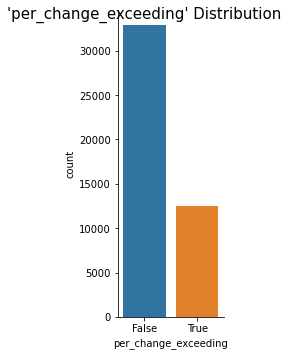

In [23]:
## ploting the distribution of response variable 
missbeat_plot = sns.catplot(x="per_change_exceeding", kind="count",data=df_final,height=5, aspect=.5)
missbeat_plot.fig.suptitle("'per_change_exceeding' Distribution",
                  fontsize=15, fontdict={"weight": "bold"})
'''Though not perfect, it is not unbalanced '''

In [26]:
### QR factorization to find the orthogonal columns to have a better conditioned matrix

## DROP the response variable 

df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])



In [30]:
%%time
print('matrix condition:  ', np.linalg.cond(df_final_explantory, p=None))

'''it is an ill-conditioned matrix as the condition value is more than 2^16; so we need to use orthogonal bases'''

matrix condition:   1.2593810138696542e+21


## Using SVD decomposition

In [31]:
# ## SVD
# from numpy import dot, diag, exp, real, sin, cosh, tanh
# from scipy.linalg import svd, svdvals

In [32]:
# def omega_approx(beta):
#     """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
#     return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

# df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])

# # do SVD and find tau star hat
# U,sv,Vh = svd(df_final_explantory, False, lapack_driver='gesvd')
# beta = min(df_final_explantory.shape) / max(df_final_explantory.shape)
# tau = np.median(sv) * omega_approx(beta)

In [33]:
# rank = round(tau) + 1
# print('Optimal Cutoff Ranks, after adjustment for rounding, for SVD as per Gavish and Donoho : ', rank) 

In [34]:
# ### top 7 column bases represent most of the variation
# percentage_of_variation = round((sum(np.diagonal(np.diag(sv[:7]))) / sum(np.diagonal(np.diag(sv))))*100 , 2)

# print('percentage of variation represented by 7 column bases :', percentage_of_variation)

In [35]:
# ## taking top columns to create lower dimension matrix
# df_lower = U[:,:7] 
# print('Size of the lower dimension matrix---')
# print(df_lower.shape)

In [36]:
# ## weighting the column bases with the inverse of variation
# # np.diag(sv[:7])
# df_lower_new = U[:,:7] @ np.linalg.inv(np.diag(sv[:7]))
# print('Size of the new lower dimension matrix---')
# print(df_lower_new.shape)

In [37]:
# df_response = pd.DataFrame(per_change_exceeding, columns =['per_change_exceeding'])
# df_response["per_change_exceeding"] = (df_response["per_change_exceeding"] == "True").astype(int)

# print(df_response['per_change_exceeding'].value_counts())

In [38]:
# # y = df_final['per_change_exceeding']  ## this is explanatory variable

# y = np.array(df_response) ## already seperated from the data and stored in the y variable. converting to array
# X = df_lower_new
# print('Size of target vector: ', y.shape)
# print('='*50)
# print('Size of explanatory matrix: ',X.shape)

In [39]:
# ## Since the data is somewhat unbalanced, I prefer to use StratifiedKFold
# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits= 5,shuffle=True,random_state=42)

# for train, test in cv.split(X,y):
#     X_train = X[train] 
#     X_test  = X[test] 
#     y_train = y[train]
#     y_test  = y[test] 
    
# print('Size of training data: ', len(X_train), 'and its shape : ', X_train.shape)
# print('Size of training labels: ', len(y_train), 'and its shape : ', y_train.shape)
# print('Size of test data: ', len(X_test), 'and its shape : ', X_test.shape)
# print('Size of test labels: ', len(y_test), 'and its shape : ', y_test.shape)

## Dense Network

In [40]:
# # defining the architecture of this connected neural network

# def build_fc_model():    
#     '''defining the model using the Sequential class'''
#     fc_model = tf.keras.Sequential([
#       # First define a input layer
#       tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),

#       # Defining the activation function for the first fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        
#       # Defining the activation function for the second fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),     

#       # Defining the activation function for the third fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),   
        
#       # Defining the second Dense layer to output the classification probabilities
#       tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, activity_regularizer=tf.keras.regularizers.L2(0.01))       
#     ])
#     return fc_model

# model = build_fc_model()
# model.summary()

In [41]:
# ## Using Adam optimizer with a learning rate of 0.01
# ## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
# ## chosing the matrix as accuracy

# learning_rate = 0.0001

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [42]:
# # Defining the batch size and the number of epochs to use during training
# BATCH_SIZE = 32
# EPOCHS = 5

# model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

## Using QR decomposition 

In [27]:
%%time
del df_final
del df_non_text_features
del SecFileName
del FileDate
del QTR
del tempdf
del File_Mon

gc.collect()
memory_usage()

CPU times: total: 7.42 s
Wall time: 36.1 s


,Size
df_final_explantory,3.43GB
per_change_exceeding,396.96KB
_7,38.27KB
TfidfVectorizer,1.96KB
_16,1.49KB
row,1.37KB
_25,1.30KB
_,1.30KB
_i19,1.08KB
_18,1.08KB


In [28]:
%%time
df_final_explantory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45382 entries, 0 to 45381
Columns: 15721 entries, FileDate_ClosingPrice to QTR_QTR4
dtypes: float64(8824), int64(1), uint8(6896)
memory usage: 3.3 GB
CPU times: total: 125 ms
Wall time: 181 ms


In [29]:
%%time
## converting datatype from float64 to float32 to reduce the size of the matrix
for col in df_final_explantory.columns:
    if df_final_explantory[col].dtype == 'float64':
        df_final_explantory[col] = df_final_explantory[col].astype('float32') 

CPU times: total: 1h 30min 20s
Wall time: 1h 31min 8s


In [30]:
%%time
df_final_explantory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45382 entries, 0 to 45381
Columns: 15721 entries, FileDate_ClosingPrice to QTR_QTR4
dtypes: float32(8824), int64(1), uint8(6896)
memory usage: 1.8 GB
CPU times: total: 2.5 s
Wall time: 2.56 s


In [31]:
%%time
### QR factorization to find the orthogonal columns to have a better conditioned matrix

# df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])
matrix = df_final_explantory.to_numpy()

CPU times: total: 14.3 s
Wall time: 15.5 s


In [33]:
%%time
del df_final_explantory

gc.collect()
memory_usage()

CPU times: total: 2.19 s
Wall time: 2.2 s


,Size
per_change_exceeding,396.96KB
_7,38.27KB
TfidfVectorizer,1.96KB
_16,1.49KB
row,1.37KB
___,1.30KB
_25,1.30KB
__,1.26KB
_27,1.26KB
_32,1.26KB


In [34]:
%%time
## qr factorization 
q, r = np.linalg.qr(matrix)

CPU times: total: 52min 11s
Wall time: 14min 4s


In [36]:
matrix.shape

(45382, 15721)

In [37]:
q.shape

(45382, 15721)

In [38]:
r.shape

(15721, 15721)

In [39]:
%%time
### putting the column bases (q) into dataframe

column_bases = [f'col_{num}' for num in range(len(np.transpose(q)))]

df_q_col_bases = pd.DataFrame(q, columns=column_bases)

df_q_col_bases.head(3)

CPU times: total: 78.1 ms
Wall time: 85.8 ms


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_15711,col_15712,col_15713,col_15714,col_15715,col_15716,col_15717,col_15718,col_15719,col_15720
0,-0.000126,-0.003643,-0.000819,0.000862,-0.000319,-0.000132,-0.000022,-0.000456,-0.000239,0.010998,...,0.005248,0.001164,0.001996,0.001482,0.003238,0.020513,0.025428,-0.009489,0.010775,0.012042
1,-0.000013,-0.004493,-0.001005,-0.000496,-0.000477,-0.000264,-0.000038,0.001397,-0.000376,-0.000532,...,0.001207,-0.000189,0.000196,0.001419,0.000100,0.032490,-0.015008,-0.101458,-0.090762,0.067302
2,-0.000019,-0.002616,-0.000585,-0.002206,-0.000380,-0.000278,-0.000036,0.003225,-0.000318,-0.000448,...,0.007152,0.003358,-0.000299,0.004651,0.002849,0.038748,-0.012786,0.017482,0.016370,0.043776


In [40]:
## new dataframe with response variable

df_response = pd.DataFrame(per_change_exceeding, columns =['per_change_exceeding'])
df_response["per_change_exceeding"] = (df_response["per_change_exceeding"] == "True").astype(int)

df_final_col_bases = pd.concat([df_response, df_q_col_bases], axis=1, join='inner')
df_final_col_bases.head(3)    

,per_change_exceeding,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_15711,col_15712,col_15713,col_15714,col_15715,col_15716,col_15717,col_15718,col_15719,col_15720
0,0,-0.000126,-0.003643,-0.000819,0.000862,-0.000319,-0.000132,-0.000022,-0.000456,-0.000239,...,0.005248,0.001164,0.001996,0.001482,0.003238,0.020513,0.025428,-0.009489,0.010775,0.012042
1,1,-0.000013,-0.004493,-0.001005,-0.000496,-0.000477,-0.000264,-0.000038,0.001397,-0.000376,...,0.001207,-0.000189,0.000196,0.001419,0.000100,0.032490,-0.015008,-0.101458,-0.090762,0.067302
2,0,-0.000019,-0.002616,-0.000585,-0.002206,-0.000380,-0.000278,-0.000036,0.003225,-0.000318,...,0.007152,0.003358,-0.000299,0.004651,0.002849,0.038748,-0.012786,0.017482,0.016370,0.043776


In [41]:
df_response['per_change_exceeding'].value_counts()

0    32904
1    12478
Name: per_change_exceeding, dtype: int64

In [43]:
%%time
del df_q_col_bases
del r
del q

gc.collect()
memory_usage()

CPU times: total: 3.22 s
Wall time: 3.31 s


,Size
df_final_col_bases,5.57GB
per_change_exceeding,396.96KB
___,368.61KB
_40,368.61KB
_39,368.60KB
df_response,177.41KB
column_bases,137.28KB
_7,38.27KB
TfidfVectorizer,1.96KB
_16,1.49KB


In [44]:
## X for explanatory variables and y for the response variable
## Normalize explanatory variables 
y = df_final_col_bases['per_change_exceeding']
X = df_final_col_bases.drop('per_change_exceeding', axis=1)

# from sklearn.preprocessing import Normalizer
# X = Normalizer().fit(X_raw)
print('Size of target vector: ', y.shape)
print('='*50)
print('Size of explanatory matrix: ',X.shape)

Size of target vector:  (45382,)
Size of explanatory matrix:  (45382, 15721)


In [45]:
%%time
del df_final_col_bases

gc.collect()
memory_usage()

CPU times: total: 23.1 s
Wall time: 7min 44s


,Size
X,5.57GB
per_change_exceeding,396.96KB
_40,368.61KB
_39,368.60KB
df_response,177.41KB
y,177.41KB
column_bases,137.28KB
_7,38.27KB
TfidfVectorizer,1.96KB
_16,1.49KB


In [51]:
## Spliting data using stratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

cross_val = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for train, test in cross_val.split(X,y):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y.iloc[train]
    y_test  = y.iloc[test] 

print('Size of training data: ', len(X_train), 'and its shape : ', X_train.shape)
print('Size of training labels: ', len(y_train), 'and its shape : ', y_train.shape)
print('Size of test data: ', len(X_test), 'and its shape : ', X_test.shape)
print('Size of test labels: ', len(y_test), 'and its shape : ', y_test.shape)

Size of training data:  36305 and its shape :  (36305, 15721)
Size of training labels:  36305 and its shape :  (36305,)
Size of test data:  9077 and its shape :  (9077, 15721)
Size of test labels:  9077 and its shape :  (9077,)


In [69]:
%%time
# del X

gc.collect()
memory_usage()

CPU times: total: 14.8 s
Wall time: 4min


,Size
X_train,4.46GB
X_test,1.11GB
y_train,425.46KB
per_change_exceeding,396.96KB
_40,368.61KB
_39,368.60KB
df_response,177.41KB
y,177.41KB
train,141.92KB
column_bases,137.28KB


In [58]:
# Normalize all of the explanatory features with StandardScaler in train and test sets
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [65]:
y_train.unique()

array([0, 1])

## Dense Network

In [70]:
# defining the architecture of this connected neural network

def build_fc_model():    
    '''defining the model using the Sequential class'''
    fc_model = tf.keras.Sequential([
      # First define a input layer
      tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),

      # Defining the activation function for the first fully connected (Dense) layer      
      tf.keras.layers.Dense(500, activation=tf.nn.relu,  kernel_initializer = "HeNormal", use_bias = True, 
                           bias_initializer='HeNormal', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        
      # Normalizing the batch to prevent from exploding  
      tf.keras.layers.BatchNormalization(),        
        
      # Adding dropout to prevent from overfitting
      tf.keras.layers.Dropout(0.5),    
        
      # Defining the activation function for the second fully connected (Dense) layer      
      tf.keras.layers.Dense(1000, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),   

      # adding dropout to prevent from overfitting 
      tf.keras.layers.Dropout(0.5),      
        
      # Defining the activation function for the third fully connected (Dense) layer      
      tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        
      # Normalizing the batch to prevent from exploding        
      tf.keras.layers.BatchNormalization(),           
        
      # Defining the second Dense layer to output the classification probabilities
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, activity_regularizer=tf.keras.regularizers.L2(0.01))       
    ])
    return fc_model

model = build_fc_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               7861000   
                                                                 
 batch_normalization_6 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_13 (Dense)            (None, 1000)              501000    
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_14 (Dense)            (None, 500)               500500    
                                                      

In [71]:
## Using Adam optimizer with a learning rate of 0.01
## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
## chosing the matrix as accuracy

learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [72]:
# Defining the batch size and the number of epochs to use during training
BATCH_SIZE = 32
EPOCHS = 10

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
1135/1135 [==============================] - 95s 82ms/step - loss: 12.0428 - accuracy: 0.6460
Epoch 2/10
1135/1135 [==============================] - 92s 81ms/step - loss: 5.3856 - accuracy: 0.7158
Epoch 3/10
1135/1135 [==============================] - 93s 82ms/step - loss: 2.6913 - accuracy: 0.7564
Epoch 4/10
1135/1135 [==============================] - 92s 81ms/step - loss: 1.4452 - accuracy: 0.7889
Epoch 5/10
1135/1135 [==============================] - 92s 81ms/step - loss: 1.0355 - accuracy: 0.8131
Epoch 6/10
1135/1135 [==============================] - 92s 82ms/step - loss: 0.9424 - accuracy: 0.8365
Epoch 7/10
1135/1135 [==============================] - 93s 82ms/step - loss: 0.9146 - accuracy: 0.8540
Epoch 8/10
1135/1135 [==============================] - 93s 82ms/step - loss: 0.9038 - accuracy: 0.8627
Epoch 9/10
1135/1135 [==============================] - 93s 82ms/step - loss: 0.8885 - accuracy: 0.8746
Epoch 10/10
1135/1135 [==============================] - 93s 82

In [73]:
## Evaluating the model with the test data

test_loss, test_acc = model.evaluate(X_test, y_test) 

print('Test loss:', test_loss)
print('----------------------------')
print('Test accuracy:', test_acc)

284/284 [==============================] - 7s 23ms/step - loss: 1.4645 - accuracy: 0.6861
Test loss: 1.4644681215286255
----------------------------
Test accuracy: 0.6861297488212585


## Converting images

In [35]:
## shape of the matrix
df_q_col_bases.shape

(45382, 9044)

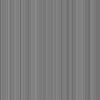

In [36]:
## Converting images from the data row
from PIL import Image 
images = df_q_col_bases.apply(lambda x: Image.fromarray(x.values.reshape(1, 9044), 'L').resize((100, 100)), axis=1)

# show image 0
images[0]

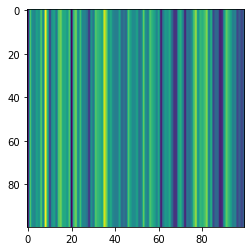

In [37]:
import matplotlib.pyplot as plt
image = images[0]
plt.imshow(image)
plt.show()

In [38]:
# images_arr = np.array(images)
## converting images (png) to tensor

imagetensor = []

for i in range(len(images)): 
    image_tensor = tf.convert_to_tensor(images[i])
    imagetensor.append(image_tensor)

In [39]:
imagetensor[20]

<tf.Tensor: shape=(100, 100), dtype=uint8, numpy=
array([[120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       ...,
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128]], dtype=uint8)>

In [40]:
image_arr = np.array(imagetensor)

In [41]:
image_arr[20]

array([[120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       ...,
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128],
       [120, 123, 125, ..., 125, 127, 128]], dtype=uint8)

In [42]:
## finding training and testing impages
X_train_img = image_arr[train]
X_test_img = image_arr[test]

In [43]:
X_train_img[20]

array([[122, 119, 132, ..., 122, 122, 126],
       [122, 119, 132, ..., 122, 122, 126],
       [122, 119, 132, ..., 122, 122, 126],
       ...,
       [122, 119, 132, ..., 122, 122, 126],
       [122, 119, 132, ..., 122, 122, 126],
       [122, 119, 132, ..., 122, 122, 126]], dtype=uint8)

### CNN 

In [44]:
X_train_img = X_train_img / 255
X_test_img = X_test_img / 255

In [45]:
X_train_img[20]

array([[0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765],
       [0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765],
       [0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765],
       ...,
       [0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765],
       [0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765],
       [0.47843137, 0.46666667, 0.51764706, ..., 0.47843137, 0.47843137,
        0.49411765]])

In [46]:
X_train_img.shape

(36306, 100, 100)

In [47]:
## CNN architecture 
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(100, (5,5), padding='same', kernel_initializer = "HeNormal", use_bias = True, 
                           bias_initializer='HeNormal', activation="relu",input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(100, (5,5), padding='same',activation="relu"),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="softmax")
]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 100)       250100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [48]:
## Using Adam optimizer with a learning rate of 0.01
## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
## chosing the matrix as accuracy

learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
# Defining the batch size and the number of epochs to use during training
BATCH_SIZE = 32
EPOCHS = 5

model.fit(X_train_img, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
1135/1135 [==============================] - 5855s 5s/step - loss: 0.7231 - accuracy: 0.2749
Epoch 2/5
1135/1135 [==============================] - 6263s 6s/step - loss: 0.6485 - accuracy: 0.2749
Epoch 3/5
1135/1135 [==============================] - 1890s 2s/step - loss: 0.6368 - accuracy: 0.2749
Epoch 4/5
1135/1135 [==============================] - 1900s 2s/step - loss: 0.6273 - accuracy: 0.2749
Epoch 5/5
1135/1135 [==============================] - 8557s 8s/step - loss: 0.6184 - accuracy: 0.2749


In [50]:
## Evaluating the model with the test data

test_loss, test_acc = model.evaluate(X_test_img, y_test) 

print('Test loss:', test_loss)
print('----------------------------')
print('Test accuracy:', test_acc)

284/284 [==============================] - 144s 508ms/step - loss: 0.5941 - accuracy: 0.2750
Test loss: 0.5940793752670288
----------------------------
Test accuracy: 0.2750110328197479


## Random Forest

In [35]:
## grid parameters
from pprint import pprint
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 4)]
max_depth = [int(x) for x in np.linspace(10, 20, num = 3)]
max_depth.append(None)
min_samples_split = [5, 10, 15]
min_samples_leaf = [5, 10, 15]
max_leaf_nodes = [5, 10]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 
               'max_leaf_nodes' : max_leaf_nodes}
pprint(random_grid)

{'max_depth': [10, 20, 30, None],
 'max_leaf_nodes': [5, 10],
 'min_samples_leaf': [5, 10],
 'min_samples_split': [5, 10],
 'n_estimators': [50, 133, 216, 300]}


In [75]:
# %%time
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# # Use the random grid to search for best hyperparameters
# clf_rf = RandomForestClassifier()

# rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, n_iter = 10,  cv = None, scoring = 'accuracy',  verbose=2, random_state=21, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)
# pprint(rf_random.best_params_)

In [76]:
%%time
from sklearn.metrics import  accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=150, 
                                random_state=42)
rf_clf.fit(X_train, y_train)
## Model evaluation 
predictions = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('-------------Model Performance----------------')   
print('Accuracy = {:0.2%}.'.format(accuracy))

-------------Model Performance----------------
Accuracy = 72.53%.
CPU times: total: 54min 40s
Wall time: 8min 50s


## XG Boost

In [43]:
# !pip install xgboost
from xgboost import XGBClassifier

In [44]:
%%time
best_xgb = XGBClassifier(n_jobs=-1, 
#                             gamma= 2,
                            learning_rate=0.2, 
                            n_estimators=400,
#                             colsample_bytree=0.5,
                            max_depth=12, 
#                             min_child_weight=0.5, 
#                             subsample=0.4,
#                             objective='binary:logistic',
#                             booster = 'dart',           
#                             sample_type = 'weighted',
#                             normalize_type = 'forest',
#                             rate_drop = 0.15,
#                             skip_drop = 0.6,
                            random_state=42)

best_xgb.fit(X_train, y_train)

CPU times: total: 2d 19h 11min 53s
Wall time: 19h 29min 56s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
%%time

yhat_xgb = best_xgb.predict(X_test) ## prediction 
accuracy = accuracy_score(y_test, yhat_xgb)

print('-------------Model Performance----------------')   
print('Accuracy = {:0.2%}'.format(accuracy))


-------------Model Performance----------------
Accuracy = 72.54%
CPU times: total: 20 s
Wall time: 4.03 s
